## Exploratory Analysis on TMDB + Other Variables Not Final 

### Are certain genres more popular?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
df = pd.read_csv('../data/tmdb.movies.csv')

In [48]:
comment = """Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37"""
id_to_genre = {line.split(' ')[-1]:line.split(' ')[0].lower() for line in comment.split('\n')}

In [49]:
id_to_genre

{'28': 'action',
 '12': 'adventure',
 '16': 'animation',
 '35': 'comedy',
 '80': 'crime',
 '99': 'documentary',
 '18': 'drama',
 '10751': 'family',
 '14': 'fantasy',
 '36': 'history',
 '27': 'horror',
 '10402': 'music',
 '9648': 'mystery',
 '10749': 'romance',
 '878': 'science',
 '10770': 'tv',
 '53': 'thriller',
 '10752': 'war',
 '37': 'western'}

In [50]:
def convert_ids(line):
    #return type(line[1:-1].split(',')[0])
    return ','.join(sorted([id_to_genre.get(x.strip(), x.strip()) for x in line[1:-1].split(',')]))

In [51]:
df['augmented_genre'] = df.genre_ids.apply(convert_ids)

In [53]:
df[df.title == 'Avatar']

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,augmented_genre
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,"action,adventure,fantasy,science"


In [107]:
df.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count',
       'augmented_genre'],
      dtype='object')

In [109]:
df.drop(columns=["Unnamed: 0", 'id'], inplace=True)

In [110]:
df[df['vote_count'] > 100]

,genre_ids,original_language,original_title,popularity,release_date,title,vote_average,vote_count,augmented_genre
0,"[12, 14, 10751]",en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"adventure,family,fantasy"
1,"[14, 12, 16, 10751]",en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"adventure,animation,family,fantasy"
2,"[12, 28, 878]",en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"action,adventure,science"
3,"[16, 35, 10751]",en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"animation,comedy,family"
4,"[28, 878, 12]",en,Inception,27.920,2010-07-16,Inception,8.3,22186,"action,adventure,science"
...,...,...,...,...,...,...,...,...,...
24462,"[28, 16, 14, 12, 35, 878]",ja,ドラゴンボール超スーパー ブロリー,6.868,2019-01-16,Dragon Ball Super: Broly,7.4,721,"action,adventure,animation,comedy,fantasy,science"
24469,"[18, 10749, 35]",fr,Le Redoutable,6.823,2018-04-20,Godard Mon Amour,6.8,160,"comedy,drama,romance"
24472,[35],en,Father of the Year,6.794,2018-07-20,Father of the Year,5.3,235,comedy
24505,[27],es,Aterrados,6.553,2018-09-21,Terrified,6.4,111,horror


In [112]:
votes_over_100 = df[df['vote_count'] > 100]

In [125]:
grouped_genre = votes_over_100.groupby('augmented_genre')

In [143]:
grouped_genre.count() > 5

,genre_ids,original_language,original_title,popularity,release_date,title,vote_average,vote_count
augmented_genre,,,,,,,,
action,True,True,True,True,True,True,True,True
"action,adventure",True,True,True,True,True,True,True,True
"action,adventure,animation",False,False,False,False,False,False,False,False
"action,adventure,animation,comedy,family",False,False,False,False,False,False,False,False
"action,adventure,animation,comedy,family,fantasy",False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
"science,thriller",True,True,True,True,True,True,True,True
"science,tv",False,False,False,False,False,False,False,False
thriller,True,True,True,True,True,True,True,True


In [144]:
genres_over_five_movies = grouped_genre.filter(lambda x: len(x) > 5)

In [148]:
genres_over_five_movies.groupby('augmented_genre').count()

,genre_ids,original_language,original_title,popularity,release_date,title,vote_average,vote_count
augmented_genre,,,,,,,,
action,11,11,11,11,11,11,11,11
"action,adventure",8,8,8,8,8,8,8,8
"action,adventure,comedy",10,10,10,10,10,10,10,10
"action,adventure,comedy,fantasy",6,6,6,6,6,6,6,6
"action,adventure,crime",6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...
"mystery,science,thriller",8,8,8,8,8,8,8,8
"mystery,thriller",21,21,21,21,21,21,21,21
science,6,6,6,6,6,6,6,6


In [149]:
genres_over_five_movies.groupby('augmented_genre').count()

,genre_ids,original_language,original_title,popularity,release_date,title,vote_average,vote_count
augmented_genre,,,,,,,,
action,11,11,11,11,11,11,11,11
"action,adventure",8,8,8,8,8,8,8,8
"action,adventure,comedy",10,10,10,10,10,10,10,10
"action,adventure,comedy,fantasy",6,6,6,6,6,6,6,6
"action,adventure,crime",6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...
"mystery,science,thriller",8,8,8,8,8,8,8,8
"mystery,thriller",21,21,21,21,21,21,21,21
science,6,6,6,6,6,6,6,6


<Axes: xlabel='augmented_genre'>

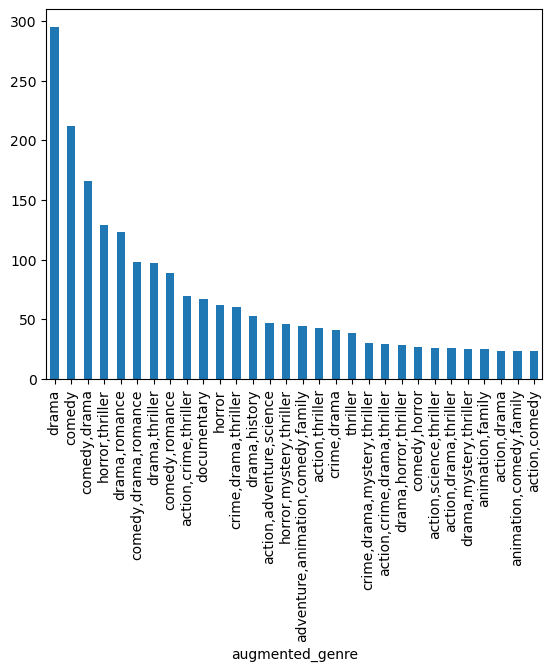

In [157]:
genres_over_five_movies.groupby('augmented_genre').count().sort_values('genre_ids', ascending=False).genre_ids.iloc[:30].plot.bar()

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\2326615085.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genres_over_five_movies.groupby('augmented_genre').median().sort_values('popularity', ascending=False).popularity.iloc[:30].plot.bar()


<Axes: xlabel='augmented_genre'>

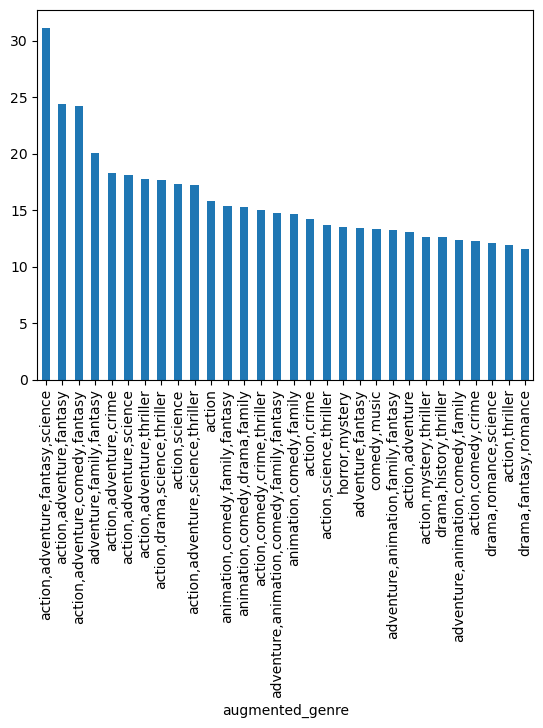

In [174]:
genres_over_five_movies.groupby('augmented_genre').median().sort_values('popularity', ascending=False).popularity.iloc[:30].plot.bar()

### Are certain years more hot in terms of popularity?

In [164]:
genres_over_five_movies['year'] = genres_over_five_movies.release_date.str.slice(stop=4)

In [173]:
over_50_movies = genres_over_five_movies.groupby('year').filter(lambda x: len(x) > 50)


In [185]:
over_50_movies.groupby('year').mean()

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\3208799122.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').mean()


,popularity,vote_average,vote_count
year,,,
2010,10.593665,6.420305,1485.284264
2011,10.144743,6.357721,1168.459559
2012,10.173396,6.274615,1319.623077
2013,9.938601,6.308589,1365.656442
2014,10.234542,6.338482,1103.243902
2015,10.838840,6.250000,1367.180000
2016,10.743977,6.377143,1478.872727
2017,11.970218,6.409302,1340.741279
2018,15.958690,6.508487,966.959410


C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\4130641119.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='vote_count')


<Axes: xlabel='year'>

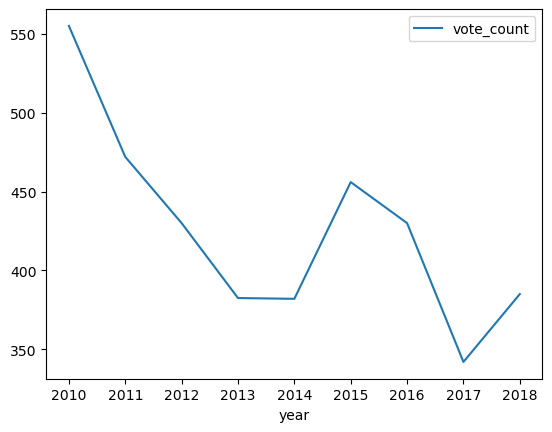

In [193]:
over_50_movies.groupby('year').median().plot.line(y='vote_count')

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\2334026813.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='vote_average')


<Axes: xlabel='year'>

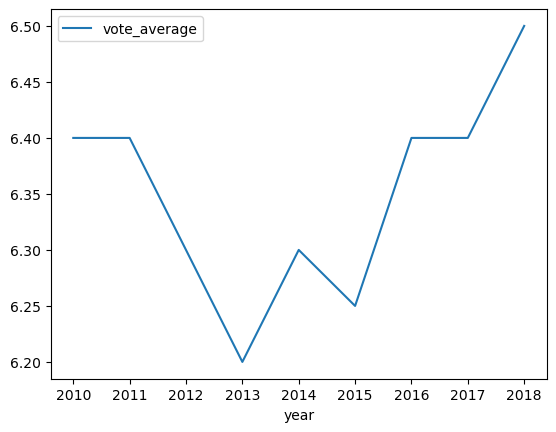

In [187]:
over_50_movies.groupby('year').median().plot.line(y='vote_average')

C:\Users\hzuo\AppData\Local\Temp\ipykernel_12364\228705581.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  over_50_movies.groupby('year').median().plot.line(y='popularity')


<Axes: xlabel='year'>

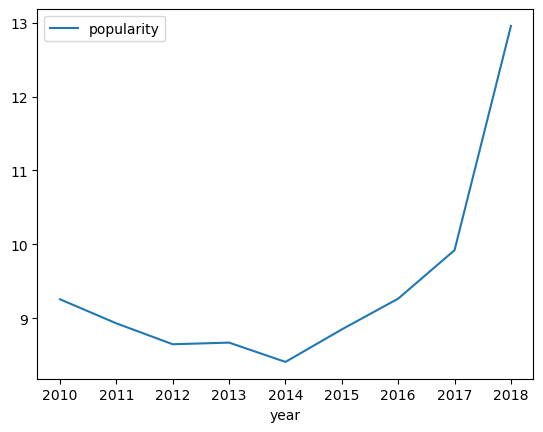

In [188]:
over_50_movies.groupby('year').median().plot.line(y='popularity')

### Other analysis - highest return on budget

In [25]:
budget_df = pd.read_csv('../data/tn.movie_budgets.csv', thousands=',')

In [26]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [27]:
budget_df.drop(columns=['id'], inplace=True)

In [28]:
budget_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [29]:
budget_df['total_gross'] = budget_df['domestic_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64) + budget_df['worldwide_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64) 

In [30]:
budget_df['pb'] = budget_df['production_budget'].str.lstrip('$').str.replace(',', '').astype(np.int64)

In [31]:
budget_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,pb
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",3536852904,425000000
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",1286727750,410600000
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",192524700,350000000
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",1862019831,330600000
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",1936903129,317000000


In [32]:
non_zero = budget_df[(budget_df.total_gross > 0) & (budget_df.pb > 0)]

In [33]:
non_zero.describe()

,total_gross,pb
count,5.415000e+03,5.415000e+03
mean,1.423993e+08,3.330801e+07
std,2.453305e+08,4.248758e+07
min,2.600000e+01,1.100000e+03
25%,1.138616e+07,6.000000e+06
50%,5.420006e+07,1.900000e+07
75%,1.612103e+08,4.200000e+07
max,3.536853e+09,4.250000e+08


In [37]:
budget_df['ropb'] = (budget_df.total_gross / budget_df.pb)

In [41]:
budget_df.sort_values(by=['ropb'], ascending=False, inplace=True)

In [42]:
budget_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,pb,ropb
5745,"Jun 30, 1972",Deep Throat,"$25,000","$45,000,000","$45,000,000",90000000,25000,3600.000000
5492,"Sep 25, 2009",Paranormal Activity,"$450,000","$107,918,810","$194,183,034",302101844,450000,671.337431
5406,"Jul 14, 1999",The Blair Witch Project,"$600,000","$140,539,099","$248,300,000",388839099,600000,648.065165
5679,"Jul 10, 2015",The Gallows,"$100,000","$22,764,410","$41,656,474",64420884,100000,644.208840
5773,"Feb 26, 1993",El Mariachi,"$7,000","$2,040,920","$2,041,928",4082848,7000,583.264000


**To target the most moviegoers with the least movies, we should look at movies made within the last [30 years](https://www.mekkographics.com/american-moviegoers-by-age-and-ethnicity/#:~:text=Younger%20Americans%20are%20more%20frequent,and%20over%20only%20attended%202.3.).**

In [44]:
last_30 = budget_df[budget_df.release_date.str.slice(start=-4).astype(int) > 1990]

In [46]:
last_30.iloc[:30]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,pb,ropb
5492,"Sep 25, 2009",Paranormal Activity,"$450,000","$107,918,810","$194,183,034",302101844,450000,671.337431
5406,"Jul 14, 1999",The Blair Witch Project,"$600,000","$140,539,099","$248,300,000",388839099,600000,648.065165
5679,"Jul 10, 2015",The Gallows,"$100,000","$22,764,410","$41,656,474",64420884,100000,644.208840
5773,"Feb 26, 1993",El Mariachi,"$7,000","$2,040,920","$2,041,928",4082848,7000,583.264000
5709,"May 7, 2004",Super Size Me,"$65,000","$11,529,368","$22,233,808",33763176,65000,519.433477
5715,"Aug 9, 1995",The Brothers McMullen,"$50,000","$10,426,506","$10,426,506",20853012,50000,417.060240
5781,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041",362082,1100,329.165455
5742,"Oct 19, 1994",Clerks,"$27,000","$3,073,428","$3,894,240",6967668,27000,258.061778
5746,"Aug 1, 1997",In the Company of Men,"$25,000","$2,883,661","$2,883,661",5767322,25000,230.692880
5507,"Jun 11, 2004",Napoleon Dynamite,"$400,000","$44,540,956","$46,122,713",90663669,400000,226.659173
